In [95]:
# trying out FRED and yahoo finance data quality/availability

from fredapi import Fred
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime


In [96]:

# retrieving data from federal reserve bank of St. Louis API

fred = Fred(api_key='c86c79e10f6477f3304072ddd403a4e8')

data = pd.DataFrame({
    'CORP_OAS': fred.get_series('BAMLC0A0CM'),
    'Unemployment': fred.get_series('UNRATE'),
    'VIX': fred.get_series('VIXCLS'),
    'T10Y2Y': fred.get_series('T10Y2Y'), # UST 2s10s spread
}).dropna()


In [97]:
data_zscores = (data - data.mean()) / data.std()
data_zscores.describe()

,CORP_OAS,Unemployment,VIX,T10Y2Y
count,2.200000e+02,2.200000e+02,2.200000e+02,2.200000e+02
mean,4.844610e-16,-5.036375e-16,-9.689219e-17,2.422305e-17
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-1.212438e+00,-1.045274e+00,-1.294704e+00,-1.914487e+00
25%,-6.198953e-01,-6.959419e-01,-7.539620e-01,-8.151549e-01
50%,-2.446183e-01,-3.466099e-01,-1.873354e-01,-1.420414e-01
75%,2.755024e-01,2.522449e-01,4.099110e-01,8.247471e-01
max,6.543286e+00,4.593943e+00,6.107112e+00,1.983854e+00


In [98]:
# have to invert the 2s10s slope z-score since more negative here will generally be a more 'stressed' move

data_zscores['T10Y2Y'] =  data_zscores['T10Y2Y']*-1

<Axes: >

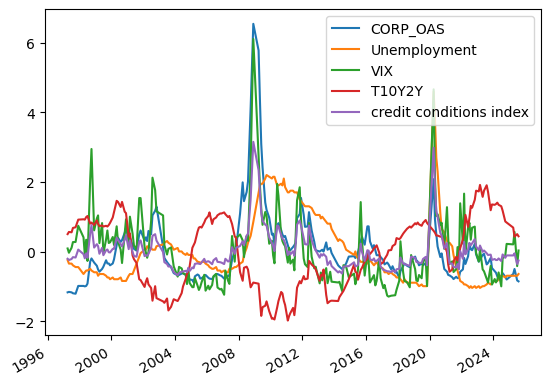

In [99]:
# combining z-scores into a single indicator to assess credit market conditions
# this will be used as a signal for risk on/risk off

data_zscores['credit conditions index'] = data_zscores.mean(axis=1)
data_zscores.plot()

/var/folders/5f/wdk48wx96tl8spk9z_l8kr280000gn/T/ipykernel_10730/691884224.py:4: FutureWarning: YF.download() has changed argument auto_adjust default to True
  yf.download('LQD', start='2005-01-01')['Close'].pct_change(),
[*********************100%***********************]  1 of 1 completed
/var/folders/5f/wdk48wx96tl8spk9z_l8kr280000gn/T/ipykernel_10730/691884224.py:5: FutureWarning: YF.download() has changed argument auto_adjust default to True
  yf.download('IEF', start='2005-01-01')['Close'].pct_change()
[*********************100%***********************]  1 of 1 completed


<Axes: xlabel='Date'>

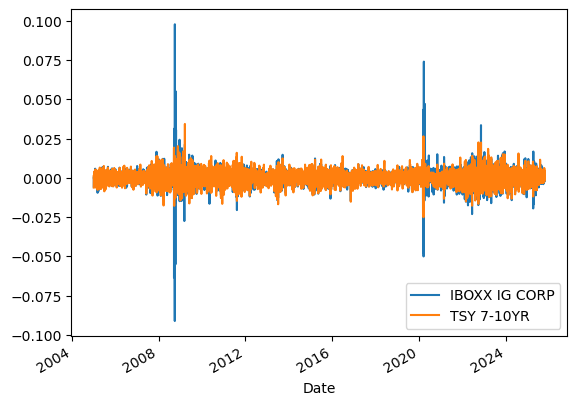

In [100]:
# retrieving mkt index total returns data from yahoo finance

market_returns = pd.concat([
    yf.download('LQD', start='2005-01-01')['Close'].pct_change(),
    yf.download('IEF', start='2005-01-01')['Close'].pct_change()
], axis=1)
market_returns.columns = ['IBOXX IG CORP', 'TSY 7-10YR']
market_returns.plot()


In [101]:
# ensuring alignment of dates

start = max(data_zscores.index.min(), market_returns.index.min())
end = min(data_zscores.index.max(), market_returns.index.max())

data_zscores = data_zscores.loc[start:end]
market_returns = market_returns.loc[start:end]

market_data_full = data_zscores.join(market_returns, how='inner')

market_data_full

,CORP_OAS,Unemployment,VIX,T10Y2Y,credit conditions index,IBOXX IG CORP,TSY 7-10YR
2005-02-01,-0.817409,-0.097087,-1.024491,0.105657,-0.458333,-0.000205,-0.000690
2005-03-01,-0.883248,-0.196896,-1.023228,0.178426,-0.481236,-0.000189,0.000012
2005-04-01,-0.712069,-0.196896,-0.764379,0.261590,-0.352938,0.000916,0.002027
2005-06-01,-0.659398,-0.296705,-0.982822,0.573458,-0.341367,0.006871,0.006169
2005-07-01,-0.685733,-0.296705,-1.104039,0.687809,-0.349667,-0.004593,-0.008605
...,...,...,...,...,...,...,...
2024-11-01,-0.804242,-0.695942,0.219247,0.833347,-0.111897,-0.005479,-0.005922
2025-04-01,-0.646230,-0.695942,0.205357,0.687809,-0.112252,0.003574,0.003513
2025-05-01,-0.501387,-0.695942,0.562695,0.427920,-0.051678,-0.003515,-0.004355
2025-07-01,-0.830577,-0.695942,-0.418405,0.500689,-0.361059,0.001209,-0.001854


In [102]:
# creating a basic buy/sell signal based on the constructed indicator. 
# dropping first row since no signal for first date

market_data_full['signal'] = (market_data_full['credit conditions index'] < 0).shift(1)  # risk on when CCI < 0
market_data_full = market_data_full.dropna()
market_data_full['strategy'] = market_data_full['signal'] * market_data_full['IBOXX IG CORP'] + ~market_data_full['signal'] * market_data_full['TSY 7-10YR']

market_data_full


/var/folders/5f/wdk48wx96tl8spk9z_l8kr280000gn/T/ipykernel_10730/1460833986.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  market_data_full['strategy'] = market_data_full['signal'] * market_data_full['IBOXX IG CORP'] + ~market_data_full['signal'] * market_data_full['TSY 7-10YR']


,CORP_OAS,Unemployment,VIX,T10Y2Y,credit conditions index,IBOXX IG CORP,TSY 7-10YR,signal,strategy
2005-03-01,-0.883248,-0.196896,-1.023228,0.178426,-0.481236,-0.000189,0.000012,True,-0.000214
2005-04-01,-0.712069,-0.196896,-0.764379,0.261590,-0.352938,0.000916,0.002027,True,-0.003137
2005-06-01,-0.659398,-0.296705,-0.982822,0.573458,-0.341367,0.006871,0.006169,True,-0.005466
2005-07-01,-0.685733,-0.296705,-1.104039,0.687809,-0.349667,-0.004593,-0.008605,True,0.012616
2005-08-01,-0.777907,-0.346610,-1.018177,0.708600,-0.358523,-0.002376,-0.001999,True,0.001623
...,...,...,...,...,...,...,...,...,...
2024-11-01,-0.804242,-0.695942,0.219247,0.833347,-0.111897,-0.005479,-0.005922,True,0.006365
2025-04-01,-0.646230,-0.695942,0.205357,0.687809,-0.112252,0.003574,0.003513,True,-0.003452
2025-05-01,-0.501387,-0.695942,0.562695,0.427920,-0.051678,-0.003515,-0.004355,True,0.005195
2025-07-01,-0.830577,-0.695942,-0.418405,0.500689,-0.361059,0.001209,-0.001854,True,0.004917


/var/folders/5f/wdk48wx96tl8spk9z_l8kr280000gn/T/ipykernel_10730/1499711357.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  market_data_full['strategy cumulative'] = (1 + market_data_full['strategy']).cumprod()


<Axes: >

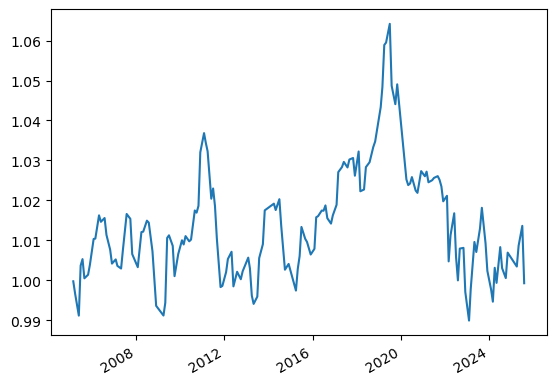

In [103]:
market_data_full['strategy cumulative'] = (1 + market_data_full['strategy']).cumprod()

market_data_full['strategy cumulative'].plot()